<a href="https://colab.research.google.com/github/meryamhzamiensi/Quantum-Enhanced-Deep-Learning-for-Precision-Drug-Design-in-Breast-Cancer-Treatment/blob/ML-models/PCD_classic_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import psutil
import tracemalloc
import time
import os
import pickle
start_time = time.time()
def track_memory_usage():
    """
    Track memory usage of the current process

    Returns:
    dict: Memory usage statistics
    """
    process = psutil.Process(os.getpid())
    memory_info = process.memory_info()

    return {
        'rss_mb': memory_info.rss / (1024 * 1024),  # Resident Set Size in MB
        'vms_mb': memory_info.vms / (1024 * 1024),  # Virtual Memory Size in MB
    }
tracemalloc.start()
# Initial memory snapshot
initial_memory = track_memory_usage()
print("Initial Memory Usage:")
print(f"RSS: {initial_memory['rss_mb']:.2f} MB")
print(f"VMS: {initial_memory['vms_mb']:.2f} MB")

Initial Memory Usage:
RSS: 948.66 MB
VMS: 5137.65 MB



Target class distribution:
LN_IC50
medium       6726
high         4457
low          1428
very_low      340
excellent     155
Name: count, dtype: int64

Final dataset shapes:
X_train: (10484, 503), y_train: (10484,)
X_test: (2622, 503), y_test: (2622,)

Model Architecture:
ImprovedMLP(
  (fc1): Linear(in_features=503, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.3, inplace=False)
  (output): Linear(in_features=32, out_features=5, bias=True)
)

Training model...
Epoch 5/100 | Train Loss: 0.3961, Acc: 0.8399 |

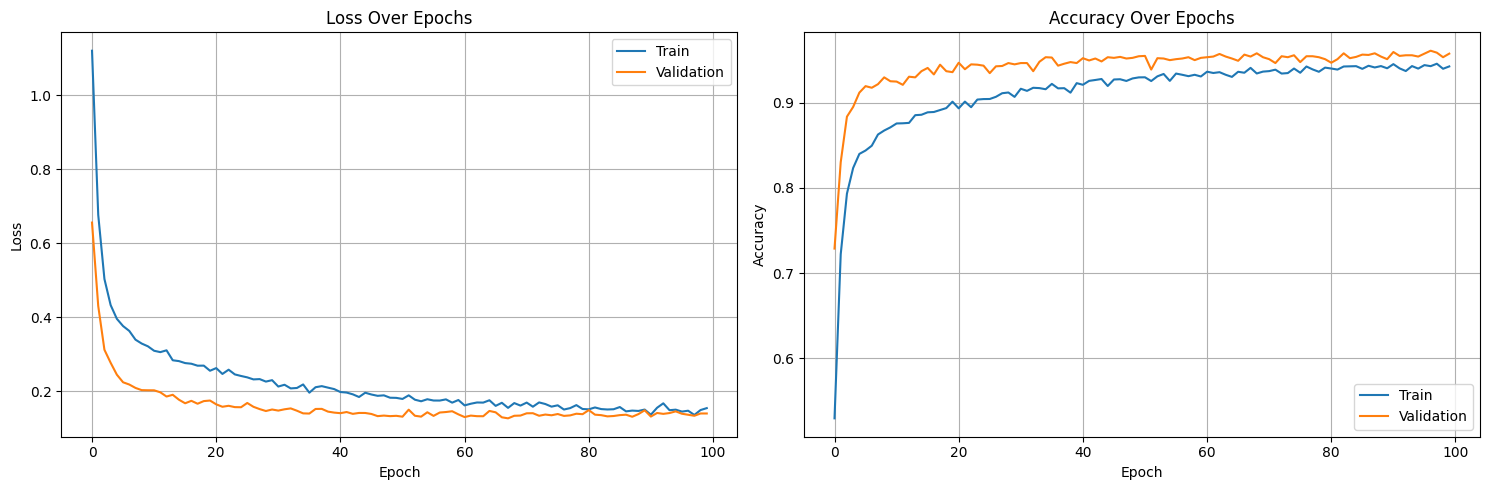


Evaluating model...

Test Loss: 0.1403, Accuracy: 0.9577

Classification Report:
              precision    recall  f1-score   support

   excellent       0.94      0.94      0.94        31
        high       0.98      0.94      0.96       892
         low       0.93      0.92      0.93       286
      medium       0.95      0.98      0.96      1345
    very_low       0.89      0.96      0.92        68

    accuracy                           0.96      2622
   macro avg       0.94      0.95      0.94      2622
weighted avg       0.96      0.96      0.96      2622



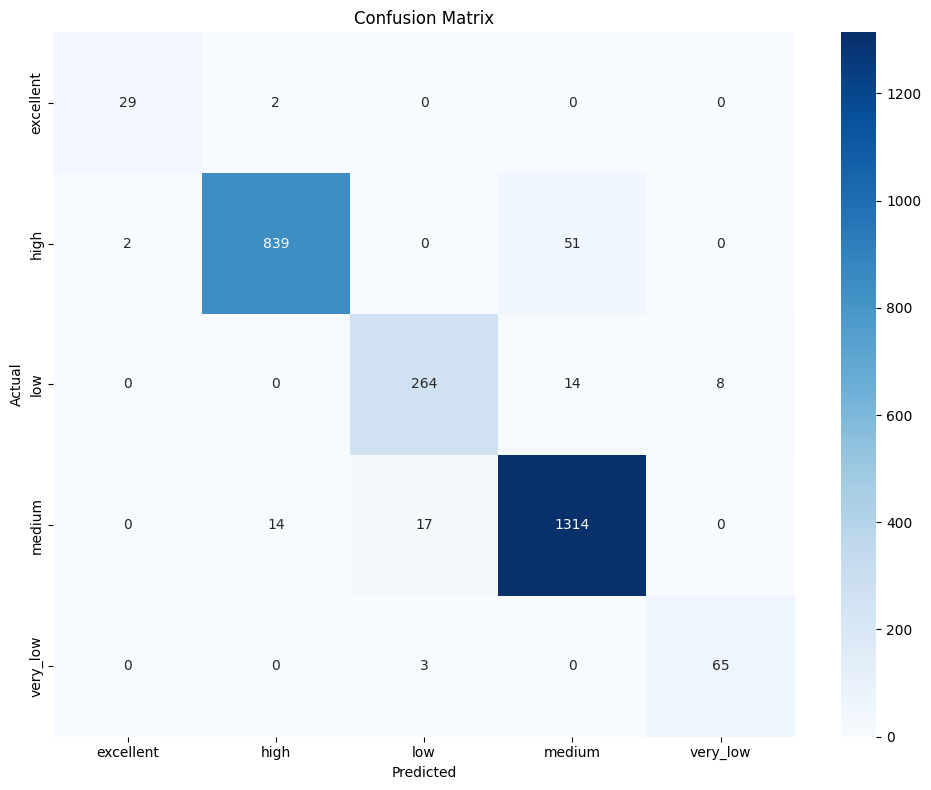


Final Memory Usage:
RSS: 1079.13 MB
VMS: 5267.37 MB
Temps d'exécution : 154.973475 secondes


In [ ]:

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Helper function to check device
def get_device():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data preprocessing function
def preprocess_data(breast_cancer_data):
    """Preprocess the breast cancer dataset."""
    y = pd.cut(
        breast_cancer_data['LN_IC50'],
        bins=5,
        labels=['very_low', 'low', 'medium', 'high', 'excellent']
    )
    print("\nTarget class distribution:")
    print(y.value_counts())

    # Encode target labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    class_names = label_encoder.classes_

    # 3. Prepare features
    X = breast_cancer_data.drop(columns=['LN_IC50'])

    # 4. Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded,
        test_size=0.2,
        random_state=42,
        stratify=y_encoded  # Maintain class distribution
    )

    print(f"\nFinal dataset shapes:")
    print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

    # 5. Feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 6. Convert to PyTorch tensors
    device = get_device()
    X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
    y_train_tensor = torch.LongTensor(y_train).to(device)
    X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
    y_test_tensor = torch.LongTensor(y_test).to(device)

    # 7. Create DataLoaders for batch processing
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    return {
        'X_train': X_train, 'X_test': X_test,
        'y_train': y_train, 'y_test': y_test,
        'X_train_scaled': X_train_scaled, 'X_test_scaled': X_test_scaled,
        'train_loader': train_loader, 'test_loader': test_loader,
        'class_names': class_names, 'input_dim': X_train.shape[1],
        'scaler': scaler, 'label_encoder': label_encoder
    }

# Improved MLP model with dropout and batch normalization
class ImprovedMLP(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128, 64, 32], output_dim=5, dropout_rate=0.3):
        super(ImprovedMLP, self).__init__()

        # Input layer -> First hidden layer
        self.fc1 = nn.Linear(input_dim, hidden_dims[0])
        self.bn1 = nn.BatchNorm1d(hidden_dims[0])
        self.dropout1 = nn.Dropout(dropout_rate)

        # Second hidden layer
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.bn2 = nn.BatchNorm1d(hidden_dims[1])
        self.dropout2 = nn.Dropout(dropout_rate)

        # Third hidden layer
        self.fc3 = nn.Linear(hidden_dims[1], hidden_dims[2])
        self.bn3 = nn.BatchNorm1d(hidden_dims[2])
        self.dropout3 = nn.Dropout(dropout_rate)

        # Output layer
        self.output = nn.Linear(hidden_dims[2], output_dim)

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        """Apply appropriate weight initialization to all layers"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        # First hidden layer
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout1(x)

        # Second hidden layer
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout2(x)

        # Third hidden layer
        x = self.fc3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.dropout3(x)

        # Output layer
        x = self.output(x)
        return x

# Training function with early stopping
def train_model(model, train_loader, test_loader, criterion, optimizer,
                num_epochs=100, patience=10, verbose=True):
    """
    Train the model with early stopping
    """
    device = get_device()
    model = model.to(device)

    # Initialize tracking variables
    train_losses = []
    test_losses = []
    train_accs = []
    test_accs = []
    best_test_loss = float('inf')
    best_model_state = None
    no_improve_count = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0

        for inputs, targets in train_loader:
            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Accumulate statistics
            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

        # Calculate epoch statistics
        epoch_train_loss = train_loss / len(train_loader.dataset)
        epoch_train_acc = correct / total
        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)

        # Evaluation phase
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, targets in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                test_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()

        # Calculate epoch test statistics
        epoch_test_loss = test_loss / len(test_loader.dataset)
        epoch_test_acc = correct / total
        test_losses.append(epoch_test_loss)
        test_accs.append(epoch_test_acc)

        # Learning rate adjustment - manual step instead of scheduler
        if epoch > 0 and epoch % 10 == 0:
            for param_group in optimizer.param_groups:
                param_group['lr'] = param_group['lr'] * 0.9

        # Early stopping check
        if epoch_test_loss < best_test_loss:
            best_test_loss = epoch_test_loss
            best_model_state = model.state_dict().copy()
            no_improve_count = 0
        else:
            no_improve_count += 1

        # Print progress
        if verbose and (epoch % 5 == 4 or epoch == num_epochs - 1):
            print(f'Epoch {epoch+1}/{num_epochs} | '
                  f'Train Loss: {epoch_train_loss:.4f}, Acc: {epoch_train_acc:.4f} | '
                  f'Test Loss: {epoch_test_loss:.4f}, Acc: {epoch_test_acc:.4f}')



    # Load best model weights
    model.load_state_dict(best_model_state)

    return model, {
        'train_losses': train_losses,
        'test_losses': test_losses,
        'train_accs': train_accs,
        'test_accs': test_accs
    }

# Evaluation function
def evaluate_model(model, test_loader, criterion, class_names):
    device = get_device()
    model = model.to(device)
    model.eval()
    test_loss = 0.0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item() * inputs.size(0)

            _, predictions = torch.max(outputs, 1)
            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    # Calculate metrics
    avg_loss = test_loss / len(test_loader.dataset)
    acc = accuracy_score(all_targets, all_predictions)

    # Display results
    print(f"\nTest Loss: {avg_loss:.4f}, Accuracy: {acc:.4f}")
    print("\nClassification Report:")
    print(classification_report(all_targets, all_predictions, target_names=class_names))

    # Compute confusion matrix
    cm = confusion_matrix(all_targets, all_predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    return {
        'accuracy': acc,
        'classification_report': classification_report(all_targets, all_predictions, target_names=class_names, output_dict=True),
        'confusion_matrix': cm
    }

# Function to visualize training history
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot training & validation loss
    ax1.plot(history['train_losses'], label='Train')
    ax1.plot(history['test_losses'], label='Validation')
    ax1.set_title('Loss Over Epochs')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Plot training & validation accuracy
    ax2.plot(history['train_accs'], label='Train')
    ax2.plot(history['test_accs'], label='Validation')
    ax2.set_title('Accuracy Over Epochs')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

# Main execution function
def run_breast_cancer_classification(breast_cancer_data):
    """
    Complete pipeline for breast cancer classification
    """
    # Preprocess data
    data = preprocess_data(breast_cancer_data)

    # Initialize model
    model = ImprovedMLP(
        input_dim=data['input_dim'],
        hidden_dims=[128, 64, 32],  # Three hidden layers
        output_dim=len(data['class_names']),
        dropout_rate=0.3
    )

    # Print model architecture
    print("\nModel Architecture:")
    print(model)

    # Setup training
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

    # Train model
    print("\nTraining model...")
    trained_model, history = train_model(
        model=model,
        train_loader=data['train_loader'],
        test_loader=data['test_loader'],
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=100,
        patience=15
    )

    # Plot training history
    plot_training_history(history)

    # Evaluate model
    print("\nEvaluating model...")
    evaluation = evaluate_model(
        model=trained_model,
        test_loader=data['test_loader'],
        criterion=criterion,
        class_names=data['class_names']
    )

    # Save model if needed
    # torch.save(trained_model.state_dict(), 'breast_cancer_model.pth')

    return trained_model, data, evaluation, history

# Usage example:

breast_cancer_data = pd.read_csv('processed_dataset.csv')
trained_model, data, evaluation, history = run_breast_cancer_classification(breast_cancer_data)

# Stop memory tracking and get final snapshot
final_memory = track_memory_usage()
print("\nFinal Memory Usage:")
print(f"RSS: {final_memory['rss_mb']:.2f} MB")
print(f"VMS: {final_memory['vms_mb']:.2f} MB")
tracemalloc.stop()

end_time = time.time()  # Arrête le chrono
execution_time = end_time - start_time  # Calcul du temps

print(f"Temps d'exécution : {execution_time:.6f} secondes")

In [ ]:
def save_as_pickle(model, filepath='model.pkl'):
    """Save entire model as .pkl file"""
    try:
        with open(filepath, 'wb') as f:
            pickle.dump(model, f)
        print(f"Model saved as {filepath}")
    except Exception as e:
        print(f"Error saving model: {e}")
        raise

save_as_pickle(trained_model, 'breast_cancer_MLP_model.pkl')

Model saved as breast_cancer_MLP_model.pkl
